In [1]:
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import numpy as np

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

In [4]:
# ! gt file과 raw image file path를 이용해 데이터를 불러온다. 
# ! train.json 파일 경로를 사용하도록 수정 필요.
data = read_json("/opt/ml/input/data/medical/ufo/train.json")

In [5]:
def get_box_size(quads):
    """ 단어 영역의 사각형 좌표가 주어졌을 때 가로, 세로 길이를 계산해주는 함수.
    TODO: 각 변의 길이를 단순히 max로 처리하기 때문에 직사각형에 가까운 형태가 아니면 약간 왜곡이 있다.
    Args:
        quads: np.ndarray(n, 4, 2) n개 단어 bounding-box의 4개 점 좌표 (단위 pixel)
    Return:
        sizes: np.ndarray(n, 2) n개 box의 (height, width)쌍
    """
    dists = []
    for i, j in [(1, 2), (3, 0), (0, 1), (2, 3)]:           # [right(height), left(height), upper(width), lower(width)] sides
        dists.append(np.linalg.norm(quads[:, i] - quads[:, j], ord=2, axis=1))

    dists = np.stack(dists, axis=-1).reshape(-1, 2, 2)      # shape (n, 2, 2) heights, widths into separate dim
    return np.rint(dists.mean(axis=-1)).astype(int)

In [6]:
def rectify_poly(poly, direction):
    """일반 polygon 형태인 라벨을 크롭하고 rectify한 형태의 가로, 세로 길이를 계산해주는 함수.
    Args:
        poly: np.ndarray(2n+4, 2) (where n>0), 4, 6, 8
        direction: 글자의 읽는 방향과 진행 방향의 수평(Horizontal) 혹은 수직(Vertical) 여부
    Return:
        rectified: np.ndarray(2, ?) rectify된 단어 bbox의 가로, 세로 길이.
    """
    
    n_pts = poly.shape[0]
    assert n_pts % 2 == 0
    if direction not in ['Horizontal', 'Vertical', 'Irregular']:
        return None
    if n_pts == 4:
        size = get_box_size(poly[None])
        h = size[:, 0]
        w = size[:, 1]
        return np.stack((h,w))

    def unroll(indices):
        return list(zip(indices[:-1], indices[1:]))

    # ! polygon 하나를 인접한 사각형 여러개로 쪼갬
    indices = list(range(n_pts))
    if direction == 'Horizontal':
        upper_pts = unroll(indices[:n_pts // 2])                # (0, 1), (1, 2), ... (4, 5)
        lower_pts = unroll(indices[n_pts // 2:])[::-1]          # (8, 9), (7, 8), ... (6, 7)

        quads = np.stack([poly[[i, j, k, l]] for (i, j), (k, l) in zip(upper_pts, lower_pts)])
    else:
        right_pts = unroll(indices[1:n_pts // 2 + 1])           # (1, 2), (2, 3), ... (4, 5)
        left_pts = unroll([0] + indices[:n_pts // 2:-1])        # (0, 9), (9, 8), ... (7, 6)

        quads = np.stack([poly[[i, j, k, l]] for (j, k), (i, l) in zip(right_pts, left_pts)])

    sizes = get_box_size(quads)
    if direction in ['Horizontal', 'Irregular']:
        h = sizes[:, 0].max()
        h = np.rint(h).astype(np.int32)
        resize_ratios = h / sizes[:, 0]
        widths = np.rint(sizes[:, 1] * resize_ratios).astype(np.int32)      # widths = sizes[:, 1]
        w = np.sum(widths)
            
        return np.vstack((h,w))
    
    elif direction == 'Vertical':
        w = sizes[:, 1].max()
        w = np.rint(w).astype(np.int32)
        resize_ratios = w / sizes[:, 1]
        heights = np.rint(sizes[:, 0] * resize_ratios).astype(np.int32)
        h = np.sum(heights)
        return np.vstack((h,w))

In [7]:
df = {}
df['image'] = []
df['word_counts'] = []
df['image_width'] = []
df['image_height'] = []
df['image_tags'] = []
img_tags = []

quads = []
polys = []
seq_length = []
hor_sizes = []
ver_sizes = []
irr_sizes = []
languages = []
orientation = []
word_height = []
word_width = []
bbox_size = []
word_tags = []
aspect_ratio = []
ver_string = []

for image_key, image_value in list(data["images"].items())[:]:

    df['image'].append(image_key)
    img_w = image_value['img_w']
    img_h = image_value['img_h']
    df['image_width'].append(img_w)
    df['image_height'].append(img_h)
    df['image_tags'].append(image_value['tags'])
    df['image_tags']= [['None'] if v is None else v for v in df['image_tags']] 
    word_ann = image_value['words']
    count_ill = 0 
    for word in word_ann.values():
        if word['illegibility']== False:
            orientation.append(word['orientation'])
            orientation = [v for v in orientation]
            seq_length.append(len(word['transcription']))
            languages.append(word['language'])
            languages = [['None'] if v is None else v for v in languages] 
            if word['tags'] != None:
                word_tags.extend(word['tags'][:])
            elif word['tags']== None:
                word_tags.append('None')
            poly = np.int32(word['points'])
            size = rectify_poly(poly, word['orientation'])
            if word['orientation'] == 'Horizontal':
                hor_sizes.append(size)
                # word_height.append(size[0])
                # word_width.append(size[1])
                bbox_size.append(np.sum(size[0]* size[1]))
            elif word['orientation'] == 'Vertical':
                ver_sizes.append(size)
                # word_height.append(size[0])
                # word_width.append(size[1])
                bbox_size.append(np.sum(size[0]* size[1]))
            else:
                irr_sizes.append(size)
                # word_height.append(size[0])
                # word_width.append(size[1])
                bbox_size.append(np.sum(size[0]* size[1]))
        else:
            count_ill += 1
    df['word_counts'].append(len(word_ann)-count_ill)
    

hor_aspect_ratio = [hor_sizes[i][1]/hor_sizes[i][0] for i in range(len(hor_sizes))]
ver_aspect_ratio = [ver_sizes[i][1]/ver_sizes[i][0] for i in range(len(ver_sizes))]

image_df = pd.DataFrame.from_dict(df)

In [8]:
image_df

,image,word_counts,image_width,image_height,image_tags
0,drp.en_ko.in_house.deepnatural_002411.jpg,375,1884,2448,[autoannotated]
1,drp.en_ko.in_house.deepnatural_002418.jpg,207,2481,3507,[autoannotated]
2,drp.en_ko.in_house.deepnatural_002432.jpg,364,3024,4032,[autoannotated]
3,drp.en_ko.in_house.deepnatural_002441.jpg,368,3120,4160,[autoannotated]
4,drp.en_ko.in_house.deepnatural_002451.jpg,364,2480,3507,[autoannotated]
...,...,...,...,...,...
95,drp.en_ko.in_house.deepnatural_003932.jpg,238,2481,3507,[autoannotated]
96,drp.en_ko.in_house.deepnatural_003951.jpg,464,2488,2304,[autoannotated]
97,drp.en_ko.in_house.deepnatural_003958.jpg,259,1440,1440,[autoannotated]
98,drp.en_ko.in_house.deepnatural_003976.jpg,250,1080,1440,[autoannotated]


In [9]:
image_df['image_tags'].apply(lambda x: x.remove("autoannotated"))
image_df['image_tags'] = image_df['image_tags'].apply(lambda x: ','.join(map(str, x)) if len(x) != 0 else "None")
image_df

0     None
1     None
2     None
3     None
4     None
      ... 
95    None
96    None
97    None
98    None
99    None
Name: image_tags, Length: 100, dtype: object

,image,word_counts,image_width,image_height,image_tags
0,drp.en_ko.in_house.deepnatural_002411.jpg,375,1884,2448,None
1,drp.en_ko.in_house.deepnatural_002418.jpg,207,2481,3507,None
2,drp.en_ko.in_house.deepnatural_002432.jpg,364,3024,4032,None
3,drp.en_ko.in_house.deepnatural_002441.jpg,368,3120,4160,None
4,drp.en_ko.in_house.deepnatural_002451.jpg,364,2480,3507,None
...,...,...,...,...,...
95,drp.en_ko.in_house.deepnatural_003932.jpg,238,2481,3507,None
96,drp.en_ko.in_house.deepnatural_003951.jpg,464,2488,2304,None
97,drp.en_ko.in_house.deepnatural_003958.jpg,259,1440,1440,None
98,drp.en_ko.in_house.deepnatural_003976.jpg,250,1080,1440,None


In [ ]:
# ! check if there are image with multiple image tags (which would apper as e.g. "document, outfocus")
set(image_df['image_tags'].tolist())

{'None'}

In [ ]:
image_df.describe()

,word_counts,image_width,image_height
count,100.000000,100.000000,100.00000
mean,311.130000,2042.700000,2612.88000
std,91.962515,856.654374,1098.84429
min,157.000000,645.000000,803.00000
25%,216.750000,1285.750000,1440.00000
50%,354.500000,2115.000000,2717.00000
75%,366.000000,2652.250000,3507.00000
max,595.000000,4032.000000,4160.00000


### Image width, height 

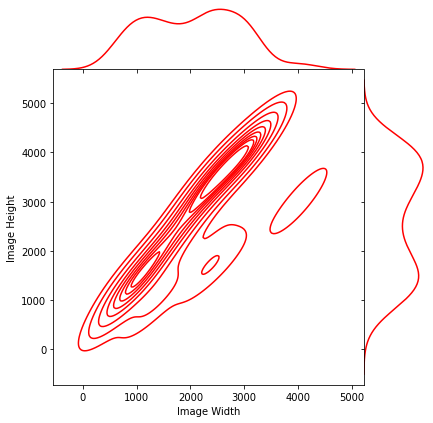

In [ ]:
g = sns.jointplot(x = "image_width", y = "image_height", data=image_df, kind="kde", space=0, color="r")
g.set_axis_labels("Image Width", "Image Height")

### Image tags, Word tags

In [ ]:
def create_count_df(df, field, index):
    count=df.groupby(field)[index].count().sort_values(ascending=False)
    count_df = count.to_frame().reset_index()
    count_df.columns = [field, field + '_count']
    return count_df

def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10,6))
    if random_sample:
        df = df.sample(n=50, random_state=1)
    bars = ax.bar(df[field], df[field + '_count'], color=color, align='center',alpha=0.5)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                df.iloc[i][field + '_count'],ha='center',fontsize=13)
    ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()
    

/tmp/ipykernel_19303/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


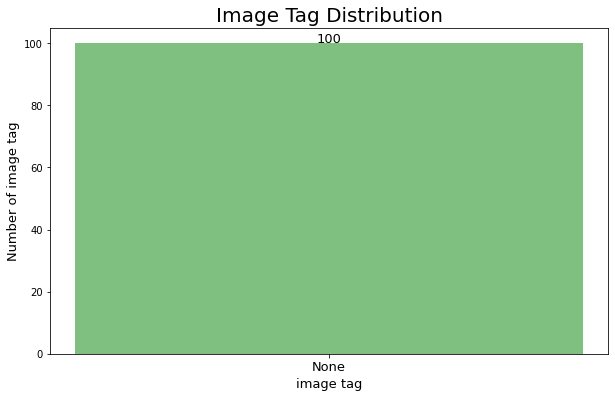

In [ ]:
img_tag_df = create_count_df(df=image_df, field='image_tags', index='image')
plot_count_df(df=img_tag_df, field='image_tags', random_sample=False, color='g', rotation=0, xlabel='image tag', \
              ylabel='Number of image tag', title='Image Tag Distribution')

/tmp/ipykernel_19303/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


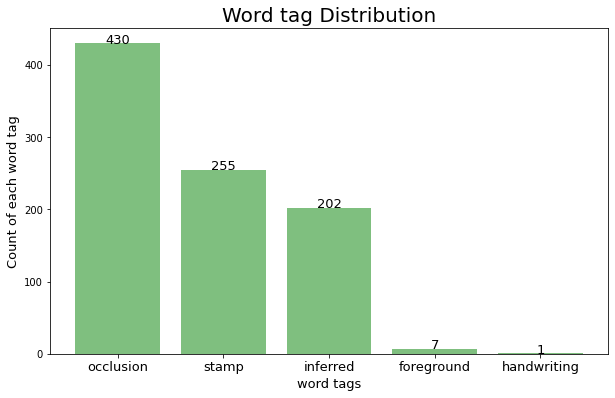

In [ ]:
# Total word tags
word_tags = [i for i in word_tags if i not in ['Auto','UpdatedBbox','UpdatedText','UpdatedTags']]
word_tag_df = pd.DataFrame(word_tags, columns = ['tags'])
word_tag_df['index'] = [i for i in range(len(word_tags))]
word_tag_df = create_count_df(word_tag_df, field='tags',index='index')
plot_count_df(df=word_tag_df, field='tags', random_sample=False, color='g', rotation=0, xlabel='word tags', \
              ylabel='Count of each word tag', title='Word tag Distribution')

### Words per Image

In [ ]:
def plot_dist(df, field, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(df[field], bins=bins, color=color, ax=ax)
    
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

/tmp/ipykernel_19303/845028883.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[field], bins=bins, color=color, ax=ax)


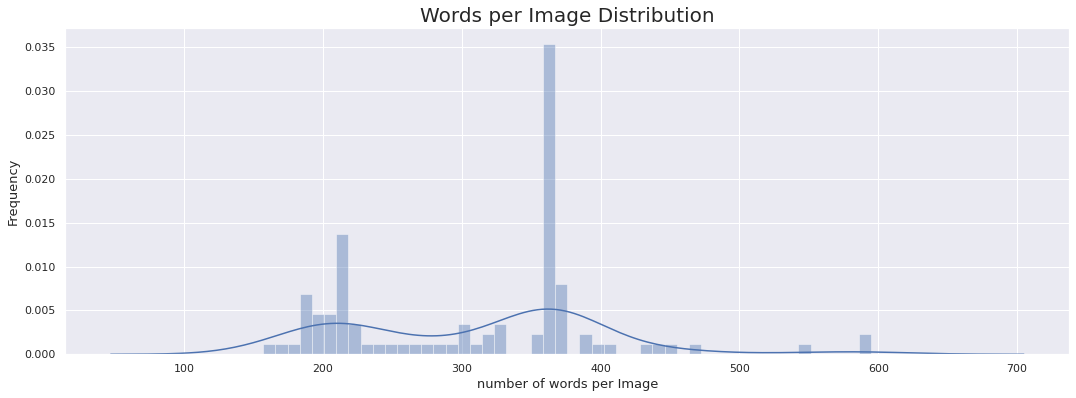

In [ ]:
plot_dist(df=image_df, field='word_counts', bins=50, color='b', xlabel='number of words per Image', \
          ylabel='Frequency', title='Words per Image Distribution')

In [ ]:
word_df ={}
word_df['index'] = [i for i in range(len(bbox_size))]
word_df['orientation'] = orientation
word_df['language'] = languages
# word_df['height'] = word_height
# word_df['width'] = word_width
word_df['bbox_size'] = bbox_size

In [ ]:
word_df = pd.DataFrame.from_dict(word_df)

In [ ]:
word_df['language'] = word_df['language'].apply(lambda x: ','.join(map(str, x)))
word_df

,index,orientation,language,bbox_size
0,0,Horizontal,None,3772
1,1,Horizontal,None,3000
2,2,Horizontal,None,4557
3,3,Horizontal,None,799
4,4,Horizontal,None,5800
...,...,...,...,...
31108,31108,Horizontal,ko,399
31109,31109,Horizontal,ko,506
31110,31110,Horizontal,ko,550
31111,31111,Horizontal,ko,483


### Orientation

/tmp/ipykernel_19303/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


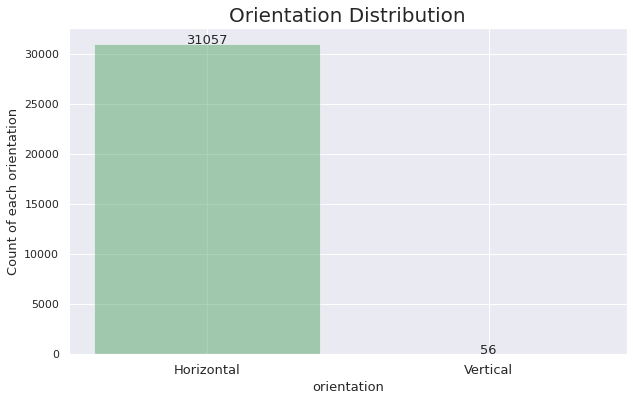

In [ ]:
orientation = create_count_df(df=word_df, field='orientation', index='index')
plot_count_df(df=orientation, field='orientation', random_sample=False, color='g', rotation=0, xlabel='orientation', \
              ylabel='Count of each orientation', title='Orientation Distribution')

### Lanaguage

/tmp/ipykernel_19303/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


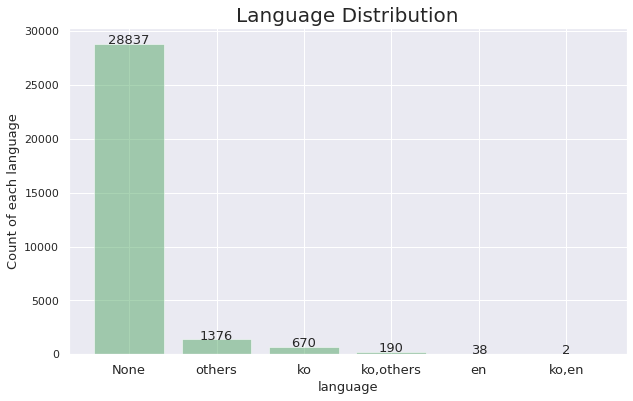

In [ ]:
# None means it's either a different language or a special symbol
lang = create_count_df(df=word_df, field='language', index='index')
plot_count_df(df=lang, field='language', random_sample=False, color='g', rotation=0, xlabel='language', \
              ylabel='Count of each language', title='Language Distribution')

### Aspect Ratio

In [ ]:
def plot_dist_list(target_list, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(target_list, bins=bins, color=color, ax=ax)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

/tmp/ipykernel_19303/1739589287.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_list, bins=bins, color=color, ax=ax)


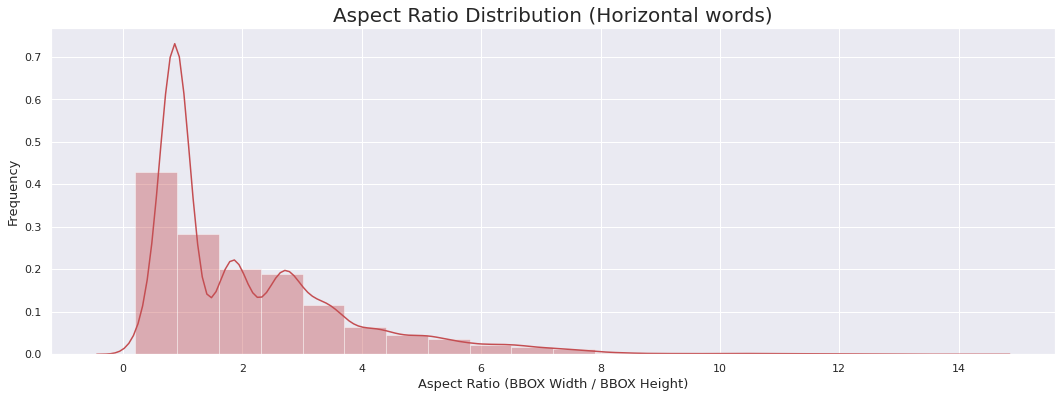

In [ ]:
# ! horizontal 단어들의 aspect ratio
# ! 한 두글자짜리 단어나 숫자의 경우 aspect ratio가 1미만인 경우가 있다
plot_dist_list(hor_aspect_ratio, bins=20, color='r', xlabel='Aspect Ratio (BBOX Width / BBOX Height)', \
          ylabel='Frequency', title='Aspect Ratio Distribution (Horizontal words)')

/tmp/ipykernel_19303/1739589287.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_list, bins=bins, color=color, ax=ax)


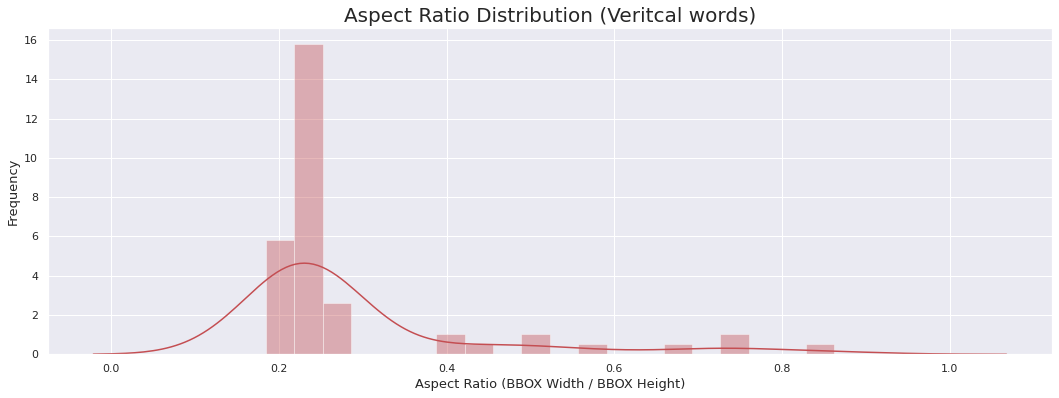

In [ ]:
# ! vertical 단어들의 aspect ration
plot_dist_list(ver_aspect_ratio, bins=20, color='r', xlabel='Aspect Ratio (BBOX Width / BBOX Height)', \
          ylabel='Frequency', title='Aspect Ratio Distribution (Veritcal words)')

### BBOX size

In [ ]:
word_df['bbox_size'].describe()

count     31113.000000
mean       2121.231704
std        3598.708463
min          15.000000
25%         440.000000
50%         858.000000
75%        2555.000000
max      136157.000000
Name: bbox_size, dtype: float64

/tmp/ipykernel_19303/845028883.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[field], bins=bins, color=color, ax=ax)


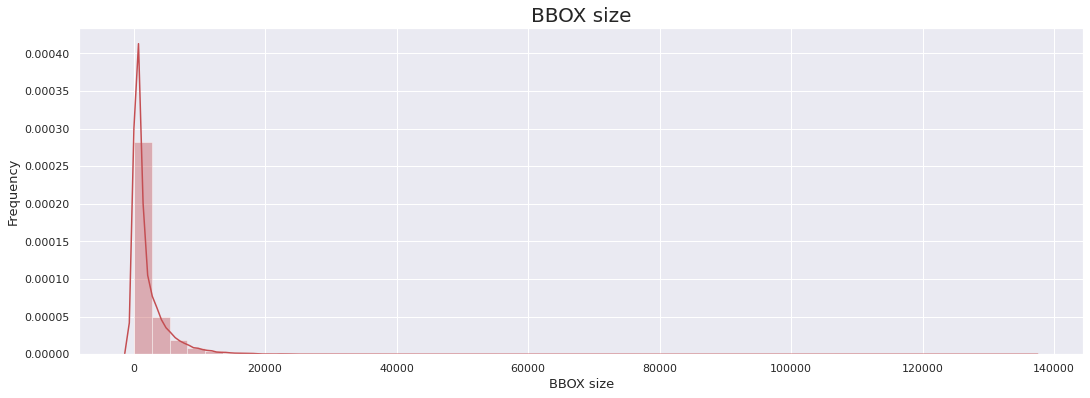

In [ ]:
# ! bbox size 분포 
plot_dist(df=word_df, field='bbox_size', bins=50, color='r', xlabel='BBOX size', \
          ylabel='Frequency', title='BBOX size')